# Importing necessary libraries 

In [4]:
# Importing libararies 
from datasets import load_dataset
from huggingface_hub import login
import regex as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import kagglehub
from wordcloud import WordCloud
import os
from collections import Counter

# Importing the dataset from HuggingFace

The dataset we are using is not publically available. Please request the authors to access this dataset

Name of Datset: HateDay, a global hate speech dataset  
Source: Tonneau et al. (2025), arXiv:2411.15462  
Available at: https://arxiv.org/abs/2411.15462

In [7]:
# Log in to Hugging Face Hub. This will prompt you to enter your token.
# You can generate a token from your Hugging Face settings page: https://huggingface.co/settings/tokens
login()

dataset = load_dataset("manueltonneau/india-hate-speech-superset")

# Previewing the dataset
print(dataset)
dataset['train'][0]

india_hf.csv:   0%|          | 0.00/5.72M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14155 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'source', 'dataset', 'nb_annotators'],
        num_rows: 14155
    })
})


{'text': 'वक्त, इन्सान और इंग्लैंड का मौसम आपको कभी भी धोखा दे सकता है।  #IndiaVsPakistan',
 'labels': 0,
 'source': 'Twitter + Facebook',
 'dataset': 'hasoc',
 'nb_annotators': '2+'}

Please find the dataset for filler words for WordCloud generation later in analysis here: 
https://www.kaggle.com/datasets/rsrishav/wordcloud-hindi-font

In [5]:
# Loading the stopwords file path, 
# this dataset includes filler words for Hindi, essential for WordCLoud generation and tokenisation
dataset_path = kagglehub.dataset_download("rsrishav/wordcloud-hindi-font")

print("Dataset downloaded to:", dataset_path)

100%|██████████| 718k/718k [00:00<00:00, 59.8MB/s]

Extracting files...
Dataset downloaded to: /home/ec2-user/.cache/kagglehub/datasets/rsrishav/wordcloud-hindi-font/versions/2


In [9]:
# Converting the HateDay dataset to pandas for convenience
df = pd.DataFrame(dataset["train"])

In [10]:
df.head()

,text,labels,source,dataset,nb_annotators
0,"वक्त, इन्सान और इंग्लैंड का मौसम आपको कभी भी ध...",0,Twitter + Facebook,hasoc,2+
1,#कांग्रेस के इस #कमीने की #करतूत को देखिए देश ...,0,Twitter + Facebook,hasoc,2+
2,पाकिस्तान को फेकना था फेका गया। जो हार कर भी द...,0,Twitter + Facebook,hasoc,2+
3,जो शब्द तूम आज किसी और औरत के लिए यूज कर रहे व...,0,Twitter + Facebook,hasoc,2+
4,नेता जी हम समाजवादी सिपाही हमेशा आपके साथ है आ...,0,Twitter + Facebook,hasoc,2+


In [11]:
df.shape

(14155, 5)

# Checking if text is written in devnagri or romanized hindi

In [12]:
# Function to check if text is mostly Devanagari
def is_hindi(text, threshold=0.5):
    # Safeguard in case of NaN or non-string
    if not isinstance(text, str):
        if pd.isna(text):
            return False
        text = str(text)
    
    # Matching Devanagari characters via Unicode range
    devanagari_chars = re.findall(r'[\u0900-\u097F]', text)
    
    if len(text) == 0:
        return False
    
    ratio = len(devanagari_chars) / len(text)
    return ratio >= threshold

In [13]:
# Applying function
df["is_hindi"] = df["text"].apply(is_hindi)
print(df["is_hindi"])

# Prining summary stats
total = len(df)
hindi_count = df['is_hindi'].sum()
print(f"total is {total}")
print(f"hindi_count is {hindi_count} out of {total}")
print(f"non_hindi is {total - hindi_count}")

0        True
1        True
2        True
3        True
4        True
         ... 
14150    True
14151    True
14152    True
14153    True
14154    True
Name: is_hindi, Length: 14155, dtype: bool
total is 14155
hindi_count is 12758 out of 14155
non_hindi is 1397


# Checking Class distribution

/tmp/ipykernel_11770/128074463.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="labels", palette="Set2")


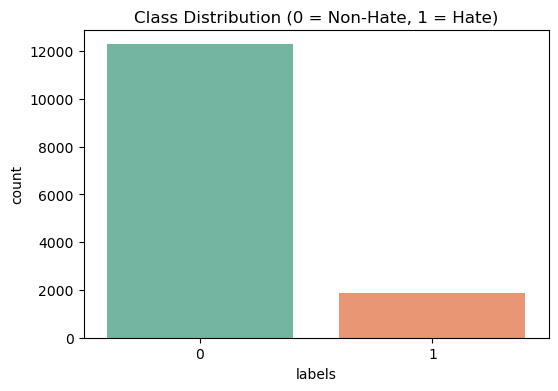

Hate proportion: 0.132 (13.2%)


In [14]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="labels", palette="Set2")
plt.title("Class Distribution (0 = Non-Hate, 1 = Hate)")
plt.show()

hate_ratio = df["labels"].mean()
print(f"Hate proportion: {hate_ratio:.3f} ({hate_ratio*100:.1f}%)")

Compared the EMSDG dataset with three labels, the HateDay datset has two labels. 

# Text Length Distribution

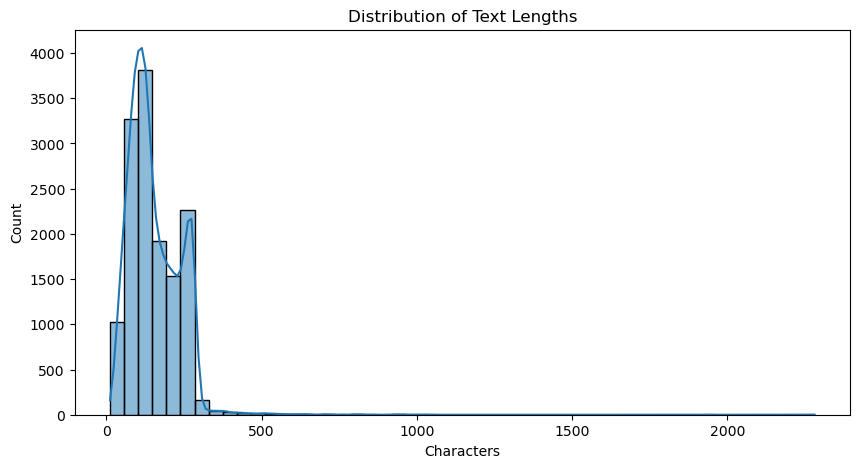

count    14155.000000
mean       153.424090
std         85.057424
min         12.000000
25%         94.000000
50%        133.000000
75%        210.000000
max       2281.000000
Name: text_len, dtype: float64


In [15]:
df["text_len"] = df["text"].apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df["text_len"], bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Characters")
plt.show()

print(df["text_len"].describe())

# Mixed Language Analysis

count    14155.000000
mean         2.402967
std          4.668141
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        102.000000
Name: eng_tokens, dtype: float64


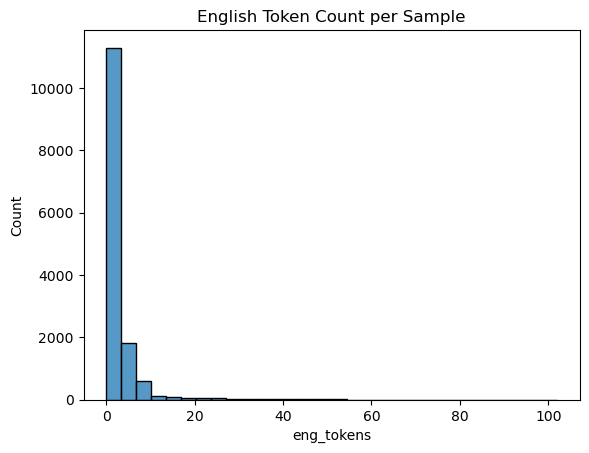

In [16]:
def count_english_tokens(text):
    tokens = re.findall(r"[a-zA-Z]+", text)
    return len(tokens)

df["eng_tokens"] = df["text"].apply(count_english_tokens)

print(df["eng_tokens"].describe())

sns.histplot(df["eng_tokens"], kde=False, bins=30)
plt.title("English Token Count per Sample")
plt.show()


# Source Distribution

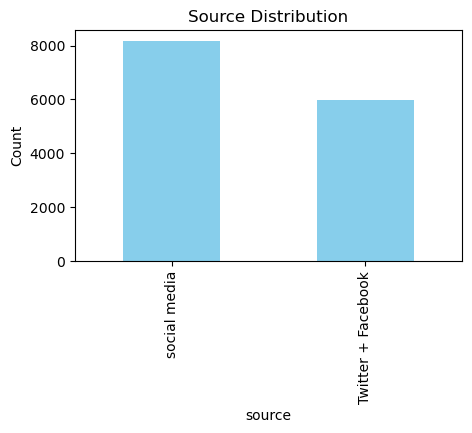

In [17]:
df["source"].value_counts().plot(kind="bar", figsize=(5,3), color="skyblue")
plt.title("Source Distribution")
plt.ylabel("Count")
plt.show()

# Annotator Distribiution

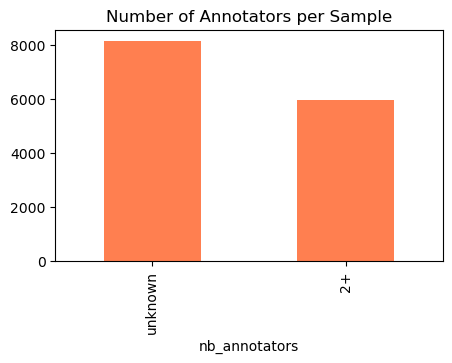

nb_annotators
2+         0.124707
unknown    0.138015
Name: labels, dtype: float64


In [18]:
df["nb_annotators"].value_counts().plot(kind="bar", figsize=(5,3), color="coral")
plt.title("Number of Annotators per Sample")
plt.show()

print(df.groupby("nb_annotators")["labels"].mean())

# Word Cloud for each class

In [19]:
# Setting the absolute path to the font in current working directory
FONT_PATH = os.path.join(os.getcwd(), "NotoSansDevanagari.ttf")
print("Font path:", FONT_PATH)
print("Exists? ", os.path.exists(FONT_PATH))

Font path: /home/ec2-user/SageMaker/NotoSansDevanagari.ttf
Exists?  True


In [20]:
# Using the hindi stopword dataset publically available on Kaggle
stopword_file = os.path.join(dataset_path, "Hindi_StopWords.txt")
print("Using stopword file:", stopword_file)

# Loading stopwords stopwords
with open(stopword_file, "r", encoding="utf-8") as f:
    hindi_stopwords = set(
        w.strip() for w in f.readlines() if w.strip()
    )

print(f"Loaded {len(hindi_stopwords)} Hindi stopwords")
print(list(hindi_stopwords)[:20]) 

Using stopword file: /home/ec2-user/.cache/kagglehub/datasets/rsrishav/wordcloud-hindi-font/versions/2/Hindi_StopWords.txt
Loaded 1 Hindi stopwords
["\ufeff'अर्थात', 'कुछ', 'तेरी', 'साबुत', 'अपनि', 'हूं', 'काफि', 'यिह', 'जा', 'दे', 'देकर', 'रह', 'कह', 'कहा', 'बात' , 'जिन्हों', 'किर', 'कोई', 'हे', 'कोन', 'रहा', 'सब', 'सो', 'तक', 'इंहें', 'इसकि', 'अपनी', 'दबारा', 'सभि', 'होते', 'भीतर', 'निचे', 'घर', 'उन्हें', 'उन्ह', 'मेरे', 'था', 'व', 'इसमें', 'उसी', 'बिलकुल', 'होति', 'गया', 'सकता', 'अपना', 'लिये', 'उसका', 'पर', 'दवारा', 'गए', 'है', 'कितना', 'भि', 'लिए', 'वुह ', 'ना', 'किसि', 'परन्तु', 'किन्हें', 'बहुत', 'भी', 'तुम्हारे', 'निहायत', 'उन्हीं', 'वहिं', 'हैं', 'उन्हों', 'इतयादि' ,'यहाँ', 'तब', 'पूरा', 'क्योंकि', 'कौनसा', 'आप', 'हुअ', 'ऐसे', 'एस', 'कारण', 'अप', 'पहले', 'तुम', 'जेसा', 'तिस', 'लेकिन', 'कहते', 'मगर', 'करता', 'संग', 'सभी', 'जीधर', 'किंहों', 'हि', 'द्वारा', 'हुआ', 'तू', 'जिंहें', 'उसने', 'पास', 'वहां', 'वह', 'किंहें', 'इंहों', 'मुझ', 'कुल', 'तिंहों', 'का', 'मेरी', 'तेरे', 'उनके',

In [21]:
with open(stopword_file, "r", encoding="utf-8") as f:
    kaggle_stopwords_raw = f.read()

# Extracting hindi stopwords using regex
kaggle_stopwords = set(re.findall(r"[\u0900-\u097F]+", kaggle_stopwords_raw))

# Adding custom stopwords
custom_stopwords = set([
    # pronouns / common words
    "मैं","मेरी","मेरा","हम","आप","तुम","वह","वे","ये","यह","जो",
    "कोई","कुछ","कौन","किस","किसी","जिस","जिसे","जिन्हें",

    # postpositions
    "का","की","के","को","से","में","पर","तो","ही","भी","और","या",
    "लेकिन","परन्तु","क्योंकि","यदि","जब","तब",

    # auxiliary verbs
    "है","हैं","हो","था","थी","थे","रहा","रही","रहे",
    "होता","होती","होते","किया","किए","कर","कहा",

    # fillers
    "नहीं","ना","न","मत","बहुत","ज्यादा","कम","कभी","हमेशा","सिर्फ", "नही", "आ", 

    # discourse particles
    "फिर","अब","अभी","तो","ही","भी",

    # question words
    "क्या","कहाँ","कब","कैसे","क्यों",
    
    # punctuation marks
    ".", ",", ";", "-", "_", ":", "?", "।", "|", "…", "!", 

    # explicitly added
    "जी","एक","अब","आज","ये","वो", "गई", "बना","गई","हमारे","चाहिए","बार","लगे","जाने","देने",
    "बन","इनके","वालो","दी","करे","ली","इतना","बनाने",
    "इनकी","इतनी","ञाए","हर","आता","लेकर","अगर",
    "लोग","लोगों","लोगो","दनि", "होगा", "@USER", "LINK", "@USER:", "श्री", "पता", "वाली", "वाला", 
    "साल", "काम", "दिन", "RT", "लिया", "नाम"
    
])

# Adding punctuation variants
punct_variants = set()
for w in custom_stopwords.union(kaggle_stopwords):
    punct_variants.add(w + "।")
    punct_variants.add(w + ".")
    punct_variants.add(w + ",")
    punct_variants.add(w + " ,")
    punct_variants.add(w + " .")
    punct_variants.add(w + ";")
    punct_variants.add(w + ":")
    punct_variants.add(w + "|")
    punct_variants.add(w + "-")
    punct_variants.add(w + "_")
    punct_variants.add(w + "?")
    punct_variants.add(w + "!")



# Generating final hindi stopword list
hindi_stopwords = kaggle_stopwords.union(custom_stopwords).union(punct_variants)

print(f"Total Hindi stopwords loaded: {len(hindi_stopwords)}")
list(hindi_stopwords)[:40]


Total Hindi stopwords loaded: 4354


['किंहों?',
 'नहीं .',
 'लोगों .',
 'उनका-',
 'रहा।',
 'हें_',
 'देने',
 'इसलिये?',
 'क्या.',
 'क्यों,',
 'नही.',
 'उंहें_',
 'द्वारा;',
 'किर|',
 'उसी .',
 'तब .',
 'हमारे ,',
 'इसकी',
 'हम:',
 'जहाँ.',
 'यहां!',
 'कैसे_',
 'नीचे_',
 'हूं',
 'मैं ,',
 '…',
 'सकते;',
 'मे,',
 'पास_',
 'क्यों;',
 ':.',
 'ऱ्वासा|',
 'तू|',
 'जो ,',
 'काफि.',
 'तरह:',
 'आदि-',
 'वह .',
 'फिर?',
 'का .']

In [26]:
# Defining a function to create wordclouds
def create_wordcloud_from_column(df, text_col, output_file, font_path, stopwords):
    # Work on a copy to avoid warnings
    df_local = df.copy()
    df_local[text_col] = df_local[text_col].fillna("").astype(str)
    text = " ".join(df_local[text_col].tolist())

    # Exacting coolwarm palette endpoints (deep blue → soft warm red)
    colors_hex = ["#3B4CC0", "#EE8669"]
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "coolwarm_custom", colors_hex
    )

    wc = WordCloud(
        width=1600,
        height=800,
        background_color="white",
        max_words=200,
        collocations=False,
        font_path=font_path,
        stopwords=stopwords,
        regexp=r"[\u0900-\u097F]+",  # Devanagari only
        colormap=cmap
    ).generate(text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()

    wc.to_file(output_file)
    print(f"✅ WordCloud saved to {output_file}")

In [27]:
# Creating hate and non_hate subsets
hate_df = df[df["labels"] == 1].copy()
non_hate_df = df[df["labels"] == 0].copy()

# Sanity check through number of samples
print("Hate samples:", len(hate_df))
print("Non-hate samples:", len(non_hate_df))

Hate samples: 1874
Non-hate samples: 12281


In [28]:
# Getting most prevelant words in both labels
def get_top_words(texts, stopwords, n=30):
    all_words = " ".join(texts).split()
    filtered = [w for w in all_words if w not in stopwords]
    return Counter(filtered).most_common(n)

top_hate = get_top_words(df[df["labels"]==1]["text"], hindi_stopwords, 30)
top_nonhate = get_top_words(df[df["labels"]==0]["text"], hindi_stopwords, 30)

print("Top hate words:\n", top_hate)
print("\n")
print("Top non-hate words:\n", top_nonhate)

Top hate words:
 [('देश', 323), ('सरकार', 184), ('भारत', 165), ('हिन्दू', 150), ('मोदी', 128), ('हरामी', 114), ('मंदिर', 112), ('साले', 111), ('पाकिस्तान', 102), ('मुस्लिम', 97), ('दिल्ली', 95), ('पुलिस', 82), ('धर्म', 82), ('कांग्रेस', 81), ('मीडिया', 79), ('मुसलमान', 77), ('पार्टी', 67), ('बीजेपी', 66), ('सुअर', 65), ('हिंदू', 64), ('राम', 63), ('जनता', 63), ('गांधी', 62), ('सूअर', 61), ('हिंदुओं', 60), ('जय', 59), ('साला', 59), ('इस्लाम', 57), ('खुद', 56), ('विरोध', 53)]


Top non-hate words:
 [('देश', 989), ('भारत', 926), ('सरकार', 692), ('मोदी', 593), ('दिल्ली', 574), ('कोरोना', 528), ('पुलिस', 487), ('प्रदेश', 385), ('जय', 294), ('भारतीय', 289), ('मीडिया', 289), ('चीन', 287), ('सिंह', 279), ('हरामी', 267), ('कांग्रेस', 266), ('मंदिर', 262), ('वीडियो', 260), ('जनता', 256), ('रंडी', 255), ('सुशांत', 252), ('मंत्री', 247), ('मुस्लिम', 240), ('पाकिस्तान', 238), ('पूर्व', 228), ('समय', 224), ('भाजपा', 221), ('नेता', 219), ('पार्टी', 218), ('प्रधानमंत्री', 211), ('लाख', 211)]


Hate Word Cloud
✅ WordCloud saved to hate_wordcloud.png


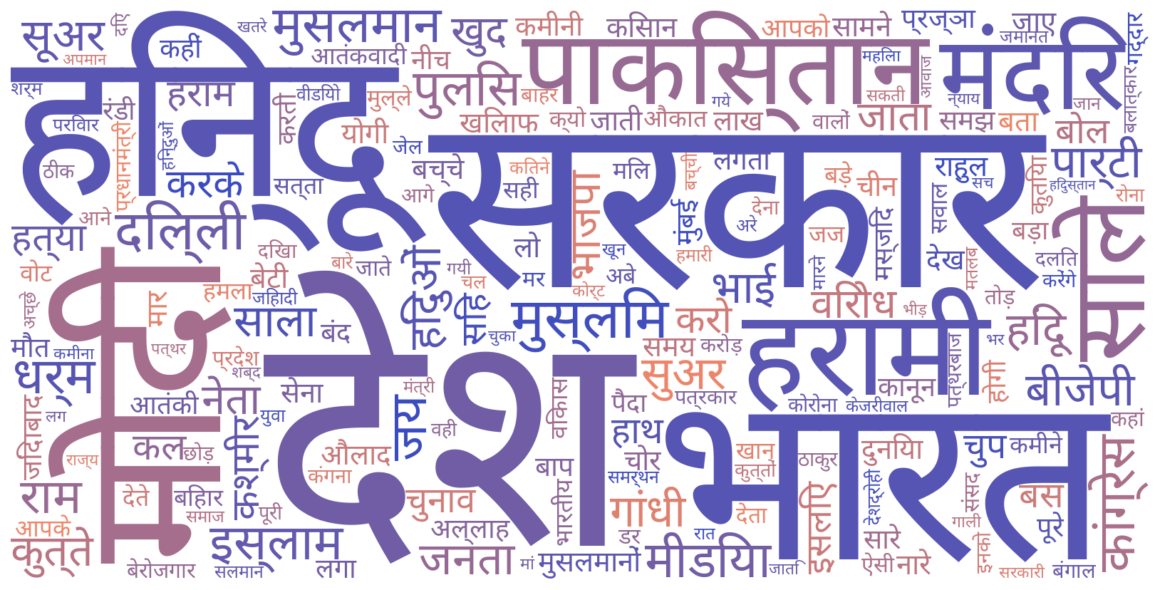

In [29]:
# Printing hindi hate word cloud
print("Hate Word Cloud")
create_wordcloud_from_column(hate_df, "text", "hate_wordcloud.png",FONT_PATH, hindi_stopwords)

Non Hate Word Cloud
✅ WordCloud saved to nonhate_wordcloud.png


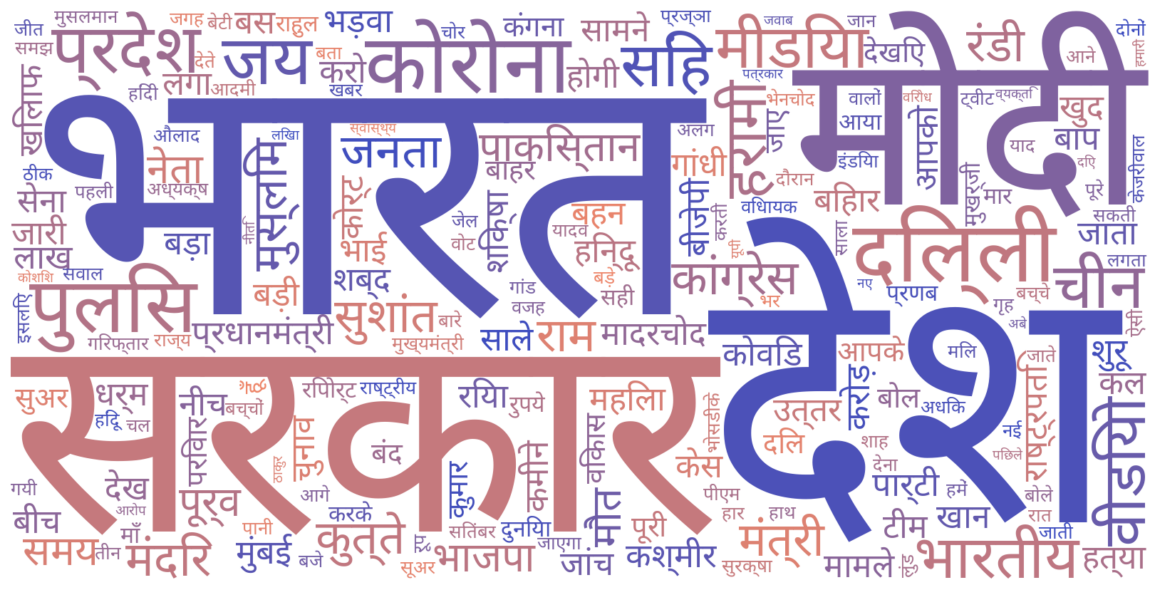

In [30]:
# Printing hindi word cloud
print("Non Hate Word Cloud")
create_wordcloud_from_column(non_hate_df, "text", "nonhate_wordcloud.png", FONT_PATH, hindi_stopwords)

# Class wise text length distrubution

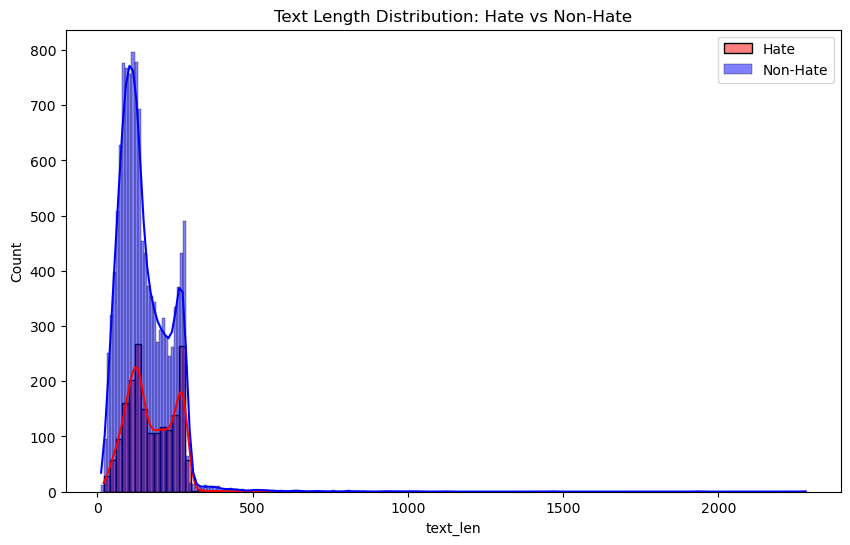

In [32]:
# Checking text length
df["text_len"] = df["text"].apply(lambda x: len(str(x)))

# Plotting histograms comparing text length of hate and non_hate labels
plt.figure(figsize=(10,6))
sns.histplot(df[df["labels"]==1]["text_len"], color="red", kde=True, label="Hate")
sns.histplot(df[df["labels"]==0]["text_len"], color="blue", kde=True, label="Non-Hate")
plt.legend()
plt.title("Text Length Distribution: Hate vs Non-Hate")
plt.show()


# Token count distributon

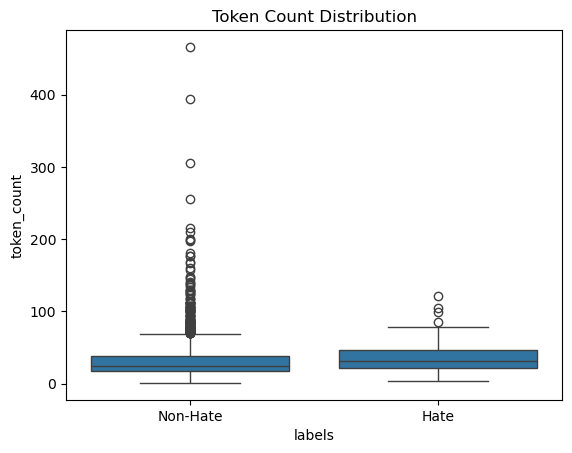

In [34]:
# Defining token count
df["token_count"] = df["text"].apply(lambda x: len(str(x).split()))

# Plotting a boxplot for token count distribution for hate and non_hate labels
sns.boxplot(data=df, x="labels", y="token_count")
plt.xticks([0,1], ["Non-Hate", "Hate"])
plt.title("Token Count Distribution")
plt.show()

# Checking for duplicates

In [59]:
df.duplicated(subset=["text"]).sum()

28

# Checking corelation between columns 

In [82]:
df[["text_len", "token_count", "labels"]].corr()

,text_len,token_count,labels
text_len,1.000000,0.976352,0.083407
token_count,0.976352,1.000000,0.103274
labels,0.083407,0.103274,1.000000
